## Forecasts from the FCH

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pyprojroot import here

In [2]:
from datetime import date

min_date = date(2021, 3, 29)
max_date = date(2021, 12, 27)

## Forecasts from the FCH

In [3]:
import pandas as pd


def forecast_long_to_wide(df: pd.DataFrame) -> pd.DataFrame:
    # Quantile column mapping
    forecast_quantiles = [
        0.01,
        0.025,
        *[round(0.05 * q, 3) for q in range(1, 20)],
        0.975,
        0.99,
    ]
    col_map = {q: f"{q * 100:.1f} %" for q in forecast_quantiles}

    # Pivot quantile rows
    q = df[df["type"] == "quantile"].copy()
    q["quantile"] = pd.to_numeric(q["quantile"])
    piv = (
        q[q["quantile"].isin(col_map)]
        .pivot(index="target_end_date", columns="quantile", values="value")
        .rename(columns=col_map)
    )

    # Add mean and sd (if present)
    res = piv.copy()
    means = (
        df[df["type"] == "mean"][["target_end_date", "value"]]
        .drop_duplicates()
        .set_index("target_end_date")
        .rename(columns={"value": "mean"})
    )
    res = res.join(means)

    # Set final column order and output
    cols = ["mean", *col_map.values()]
    out = res[cols].reset_index().rename(columns={"target_end_date": "date"})
    return out

In [4]:
import os
from pathlib import Path
import subprocess
import pandas as pd

# Define repository and local clone directory
repo_url = (
    "https://github.com/european-modelling-hubs/covid19-forecast-hub-europe_archive.git"
)
clone_dir = Path("/tmp/covid19-forecast-hub-europe_archive")


def read_fch_submissions(model_dir: str) -> pd.DataFrame:
    csv_dir_path = clone_dir / model_dir
    csv_files = [
        csv_dir_path / file
        for file in os.listdir(csv_dir_path)
        if file.endswith(".csv")
    ]

    dfs = [
        pd.read_csv(file_path).assign(filename=file_path.name)
        for file_path in csv_files
    ]
    combined_df = pd.concat(dfs, ignore_index=True)

    query_string = "target == '1 wk ahead inc case' and location == 'DE'"

    wide_df = forecast_long_to_wide(
        combined_df.query(query_string)[
            ["target_end_date", "type", "quantile", "value"]
        ]
    )

    wide_df["date"] = pd.to_datetime(wide_df["date"], format="%Y-%m-%d").dt.date

    return wide_df[(wide_df["date"] >= min_date) & (wide_df["date"] <= max_date)]


if not clone_dir.exists():
    subprocess.run(
        ["git", "clone", "--depth", "1", repo_url, str(clone_dir)], check=True
    )

model_names = ["ITWW-county_repro", "EuroCOVIDhub-baseline", "EuroCOVIDhub-ensemble"]

models = {name: read_fch_submissions(f"data-processed/{name}") for name in model_names}

itww_county_repro = models["ITWW-county_repro"]
baseline = models["EuroCOVIDhub-baseline"]
ensemble = models["EuroCOVIDhub-ensemble"]

In [5]:
truth = (
    pd.read_csv(here("data/processed/RKI_county_weekly.csv"))
    .groupby("date")
    .agg(cases=("cases", "sum"))
)
truth["date"] = pd.to_datetime(truth.index, format="%Y-%m-%d").date
truth.reset_index(drop=True, inplace=True)

In [6]:
truth = truth[(truth["date"] >= min_date) & (truth["date"] <= max_date)]

In [7]:
truth.date.iloc[0], itww_county_repro.date.iloc[0]

(datetime.date(2021, 4, 3), datetime.date(2021, 4, 3))

In [8]:
assert all(truth.date.values == itww_county_repro.date.values)
assert all(truth.date.values == baseline.date.values)
assert all(truth.date.values == ensemble.date.values)

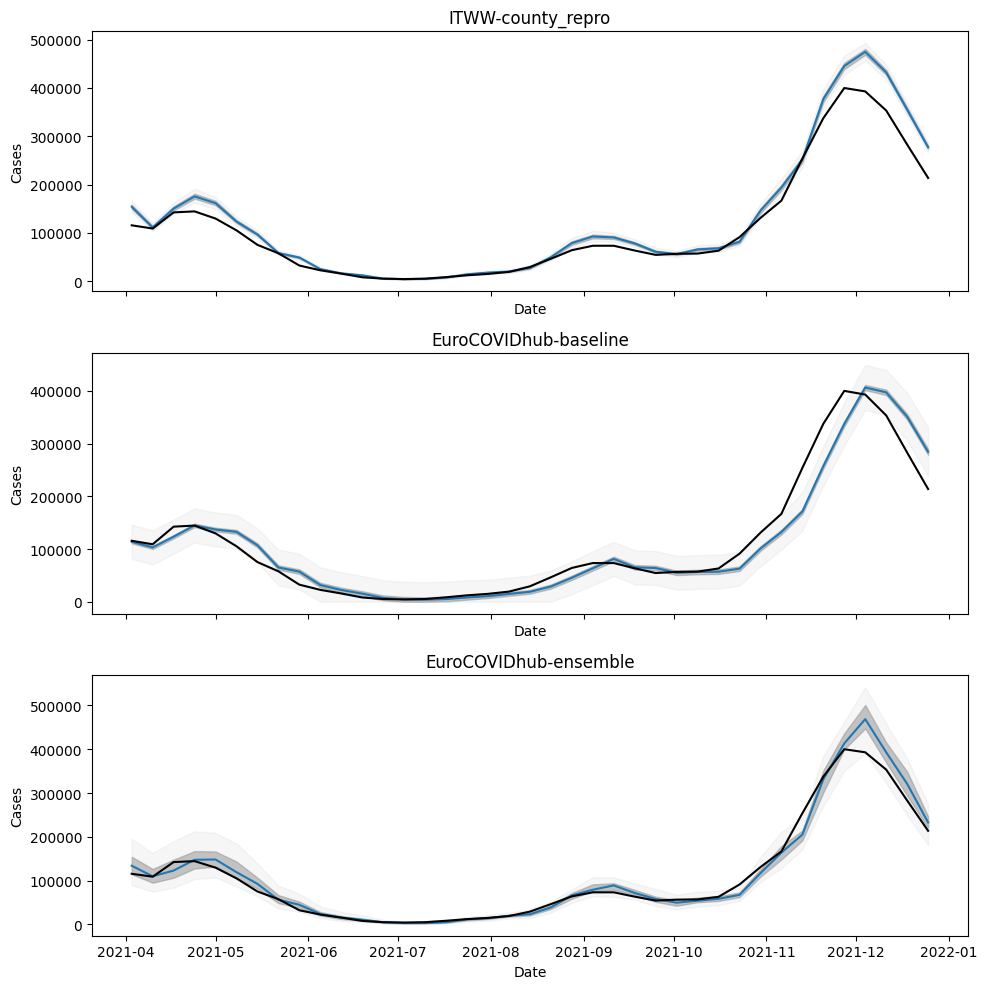

In [9]:
fig, axs = plt.subplots(3, figsize=(10, 10), sharex=True)

for ax, model_name in zip(axs, model_names):
    df = models[model_name]
    ax.plot(df.date, df["50.0 %"])
    ax.fill_between(df.date, df["25.0 %"], df["75.0 %"], color="gray", alpha=0.5)
    ax.fill_between(df.date, df["2.5 %"], df["97.5 %"], color="lightgray", alpha=0.2)
    ax.set_title(model_name)

    ax.plot(truth["date"], truth["cases"], color="black")
    ax.set_ylabel("Cases")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()

In [10]:
for model, df in models.items():
    df.to_csv(here(f"data/processed/ECDC_FCH_{model}.csv"), index=False)